In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

We will take a look at one such feature extraction technique, the Histogram of Oriented Gradients (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination. We will use these features to develop a simple face detection pipeline, using machine learning algorithms.

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. HOG involves the following steps:

1) Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination. \
2) Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information. \
3) Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell. \
4) Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image. \
5) Construct a one-dimensional feature vector from the information in each cell. 

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

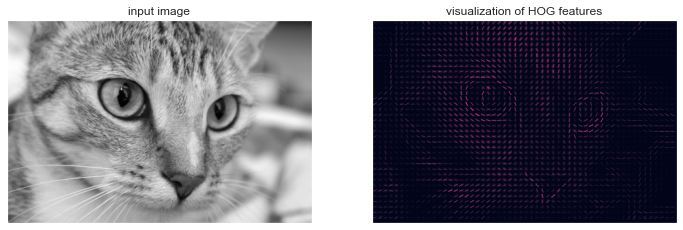

In [6]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## HOG in Action: A Simple Face Detector
Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine.The steps are as follows:

1) Obtain a set of image thumbnails of faces to constitute "positive" training samples. \
2) Obtain a set of image thumbnails of non-faces to constitute "negative" training samples. \
3) Extract HOG features from these training samples. \
4) Train a linear SVM classifier on these samples. \
5) For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not. \
If detections overlap, combine them into a single window.

## 1. Obtain a set of positive training samples

In [9]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
positive_patches = faces.images
positive_patches.shape

(1806, 62, 47)

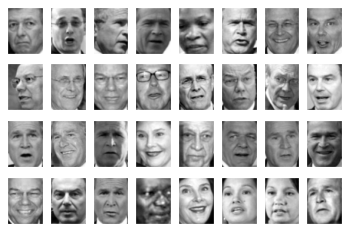

In [10]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

## 2. Obtain a set of negative training samples

In [11]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

C:\Users\gupt1\AppData\Local\Temp/ipykernel_17276/4073325644.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


(30000, 62, 47)

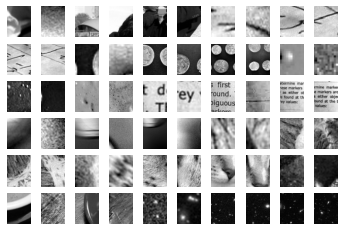

In [12]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

## 3. Combine sets and extract HOG features

In [13]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [14]:
X_train.shape

(31806, 1215)

## 4. Training a support vector machine

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.96353348, 0.99119635, 0.99308285, 0.99559818, 0.99324006])

In [19]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\gupt1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\gupt1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\gupt1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\gupt1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\gupt1\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

0.9963843695230796

In [20]:
grid.best_params_

{'C': 1.0}

In [21]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

## 5. Find faces in a new image

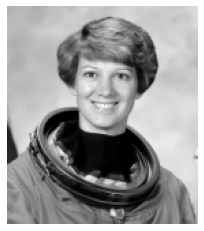

In [22]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [23]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [24]:
labels = model.predict(patches_hog)
labels.sum()

25.0

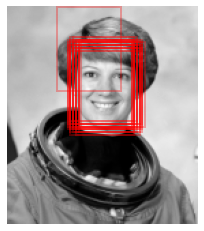

In [25]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))